# RP3 — Mathematics Notebook (Energy Resource Modelling)

**What this notebook is:** a guided, self-contained mathematics + data notebook to support your project write-up.  
You will use calculus (integrals), differential equations (ODEs), and numerical methods (numerical integration, numerical ODE solving) to model an energy resource and explore “what-if” scenarios relevant to your assigned technology.

**What you will submit:**  
1. This notebook, **completed and run end-to-end** (all cells executed, no errors).  
2. The notebook must be stored in a **public GitHub repository** shared among all group members (one repo per group).  
   - Include a short `README.md` describing what you did and how to run the notebook.
   - Everyone in the group should have access and should contribute.

**Use in your write-up:**  
You are **encouraged (not required)** to incorporate figures, calculations, and conclusions from this notebook into your final project submission. If you do, cite your GitHub repo and refer to the relevant sections/cells.

---

## Technologies supported in this notebook

- Fermentation  
- Water  
- Solar  
- Wind  
- Nuclear fission  
- Geothermal  

You will choose **one** technology below corresponding to your Phase 2 assignment, and the notebook will follow the appropriate branch.


In [47]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

DATA_DIR = Path("data")  # assumes you keep the data folder next to this notebook

TECH_OPTIONS = ["Fermentation","Water","Solar","Wind","Nuclear Fission","Geothermal"]
TECH = "Wind"  # <-- CHANGE ME

assert TECH in TECH_OPTIONS, f"TECH must be one of {TECH_OPTIONS}"
TECH

'Wind'

## About the data

To keep difficulty equitable across groups, this notebook ships with datasets for each technology.

- **Solar & Wind** use hourly weather data for 2025 from **Open-Meteo** (Hamilton coordinates), including wind speed and solar radiation.  
  Reference: Open-Meteo Historical Weather API documentation.

- **Fermentation** uses a **small sample** derived from the NYC DEP “Wastewater Co-digestion and Biogas-to-grid Performance Indicators” *schema* and plausible ranges.
  - This is included so you can proceed immediately and practice the methods.
  - If you want to swap in the full official dataset later, a short “how-to” link is provided below.

- **Water, Nuclear, Geothermal** are provided as **representative time series** bundled with this notebook so every group can proceed uniformly.
  - These are intentionally “clean” datasets so your effort is focused on modelling and interpretation.
  - If you locate high-quality primary data for your specific case study, you can replace these files without changing the notebook logic.

**Key point:** You do *not* need to hunt for data to complete the notebook. **Optionally:** you may wish to use data that you are able to find which is more specific to your region. This is encouraged, but not required. If you would like to use your own sourced data, please seek approval from your instructor.

**References**
- Open-Meteo docs: https://open-meteo.com/en/docs/historical-weather-api  
- NYC dataset landing page (biogas): https://catalog.data.gov/dataset/wastewater-co-digestion-and-biogas-to-grid-performance-indicators  


In [48]:
def load_data_for_tech(tech: str) -> pd.DataFrame:
    """Load the packaged dataset associated with a technology choice."""
    if tech in ["Solar","Wind"]:
        return pd.read_csv(DATA_DIR / "hamilton_2025_wind_solar_openmeteo.csv", parse_dates=["time"])
    if tech == "Fermentation":
        return pd.read_csv(DATA_DIR / "nyc_wrrf_biogas_monthly_sample.csv")
    if tech == "Water":
        return pd.read_csv(DATA_DIR / "water_daily_flow_synthetic_2025.csv", parse_dates=["date"])
    if tech == "Nuclear Fission":
        return pd.read_csv(DATA_DIR / "nuclear_hourly_synthetic_2025.csv", parse_dates=["time"])
    if tech == "Geothermal":
        return pd.read_csv(DATA_DIR / "geothermal_hourly_synthetic_2025.csv", parse_dates=["time"])
    raise ValueError(f"Unknown tech: {tech}")

df = load_data_for_tech(TECH)
df.head()

,time,windspeed_10m_m_s,shortwave_radiation_W_m2
0,2025-01-01 00:00:00,18.3,0.0
1,2025-01-01 01:00:00,18.7,0.0
2,2025-01-01 02:00:00,20.3,0.0
3,2025-01-01 03:00:00,19.3,0.0
4,2025-01-01 04:00:00,18.8,0.0


## Phase 1 — Characterize the resource with calculus and data

In Phase 1 you will:

1. Use **Pandas** to summarize the dataset.
2. Use **numerical integration** (e.g., the trapezoid rule) to convert a *power or rate* time series into an *energy or total amount* over a period (Section 7.7 in Edition 9 of the textbook).
3. Build a **first-pass model** that maps “measured variables” → “power output”.

A recurring mathematical idea is:

> If $P(t)$ is power (Watts) at time $t$, then total energy over $[t_0,t_1]$ is  
> $$
E = \int_{t_0}^{t_1} P(t)\,dt.
$$
With discrete data, we approximate the integral numerically.

### Numerical integration (trapezoid rule)
If we have values $P_0,P_1,\dots,P_n$ at equally spaced times with spacing $\Delta t$, then
$$
\int P(t)\,dt \approx \Delta t\Big(\tfrac{1}{2}P_0 + P_1 + \cdots + P_{n-1} + \tfrac{1}{2}P_n\Big).
$$

Implement this below using a loop:


In [49]:
def trapz_integral(y: np.ndarray, dt: float) -> float: #y is what you are integrating, dt is the spacing
    """Approximate integral of y(t) dt using trapezoid rule for evenly-spaced samples."""
    total = 0.0 #starting value
     
    for i in range (len(y)-1):
      trapezoide_area = 0.5 * (y[i]+ y[i+1]) * dt
      total += trapezoide_area
    return total

    return "This function needs to be implemented"

# quick demo on a known function: integral of sin from 0 to pi is 2
# We can test this against numpy's built-in trapezoid rule implementation
x = np.linspace(0, np.pi, 100)
y = np.sin(x)
dx = x[1] - x[0]
your_result = trapz_integral(y, dx)
numpy_result = np.trapezoid(y, dx=dx)
print(f"Our result: {your_result}, Numpy result: {numpy_result}")

Our result: 1.9998321638939935, Numpy result: 1.9998321638939927


### Check 1 (embedded)

This is a quick self-check. It is not separately graded, but you should keep checks passing.


In [50]:
# Check 1: integral of sin from 0 to pi should be close to 2
assert type(your_result) != float, "trapz_integral should return a float"
assert abs(your_result - 2.0) < 1e-3
"Check 1 passed" 

'Check 1 passed'

## Branch: Wind

### Physical idea

Wind turbines convert kinetic energy in moving air into electrical power. A very simplified model:
$$
P(t) = \tfrac{1}{2}\,\rho\,A\,C_p\,v(t)^3
$$
where
- $\rho$ = air density (kg/m³), about 1.2 at sea level
- $A$ = swept area of the rotor (m²)
- $C_p$ = power coefficient (dimensionless), bounded above by the Betz limit (~0.593); practical values are lower
- $v(t)$ = wind speed (m/s)

Real turbines have cut-in / rated / cut-out speeds and a manufacturer power curve.

Reference:  
- https://en.wikipedia.org/wiki/Wind_turbine_aerodynamics  
- (For a more technical and reputable engineering overview) NREL wind basics: https://www.nrel.gov/research/re-wind.html

### Your task

1. Choose reasonable parameters (rotor radius, $C_p$, etc.) and justify.
2. Compute a power time series and annual energy.
3. Add at least one plot and interpret.



Estimated annual energy: 30,873,111 kWh


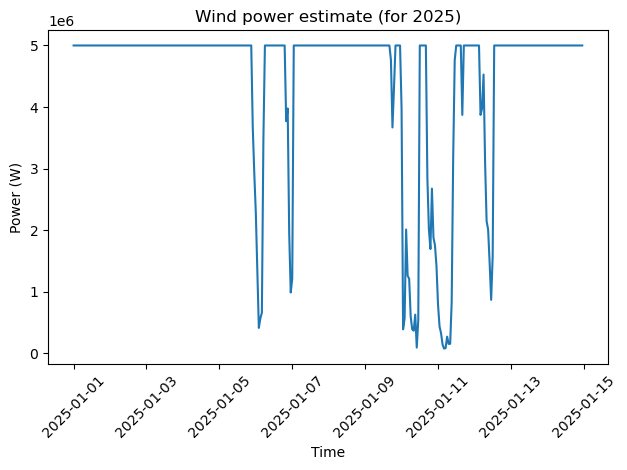

In [51]:
if TECH == "Wind":
    df_ws = df.copy()
    rho = 1.2 # TODO: air density (kg/m^3)
    Cp = 0.45  # TODO: power coefficient (dimensionless)
    radius_m = 57  # TODO: rotor radius (m) 
    rated_power_W = 5.0e6
    if np.isnan(rho) or np.isnan(Cp) or np.isnan(radius_m) or np.isnan(rated_power_W):
        raise ValueError("Set rho, Cp, radius_m, rated_power_W (and justify) before running the Wind branch.")

    A = np.pi * radius_m**2 # rotor swept area (m^2)

    v = df_ws["windspeed_10m_m_s"].to_numpy()
    P_W = 0.5*rho*A*Cp*v**3 # TODO: compute wind power in Watts using rho, A, Cp, and v 

    # Optional (recommended): cap at a rated power to avoid absurd values in this toy model
    rated_power_W = 5.0e6  # TODO: rated power cap (W)
    P_W = np.minimum(P_W, rated_power_W)

    df_ws["power_W"] = P_W
    E_kWh = (trapz_integral(P_W, 3600.0) / 3600.0) / 1000.0
    print(f"Estimated annual energy: {E_kWh:,.0f} kWh")

    window = df_ws.iloc[0:24*14].copy() #here is were you select the 7 days
    plt.figure()
    plt.plot(window["time"], window["power_W"])
    plt.title("Wind power estimate (for 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Power Coefficient Cp= 0.45. Limited by Betz law, the maximum theoretical efficiency of turbines converting wind energy to electricity is 59%, however most modern wind turbines have an efficiency of 34-45%, thus choosing 45% is a typical representation of wind turbines in Canada (Liu et al. 2011). 

Rotor blade radius - The chosen radius for the rotor blades was 57 m. This parameter is taken from data from 2018, so they could be larger. However, due to experiments in our research lab, there is evidence that suggest with a larger radius, the efficiency is worse. Thus, resulting in less energy produced (Government of Canada 2023). 

References

Government of Canada, Canada Energy Regulator. 2023. “CER – Market Snapshot: Wind Turbines in Canada Have Increased in Both Size and Generation Capacity.” November 28. https://www.cer-rec.gc.ca/en/data-analysis/energy-markets/market-snapshots/2019/market-snapshot-wind-turbines-in-canada-have-increased-in-both-size-generation-capacity.html.

Liu, X., L. Wang, and X. Tang. 2011. “Investigation on the Impact of Design Wind Speed and Control Strategy on the Performance of Fixed-Pitch Variable-Speed Wind Turbines.” Renewable Energy and Power Quality Journal 9 (1). https://doi.org/10.24084/repqj09.528.

## Branch: Water (hydro)

### Modelling idea

Hydro power depends on flow rate $Q$ and head $H$:
$$
P = \eta\,\rho\,g\,Q\,H
$$
where
- $Q$ is flow (m³/s),
- $H$ is head (m),
- $\rho$ is water density (~1000 kg/m³),
- $g\approx 9.81\,\text{m/s}^2$.

The dataset provides a daily flow time series `flow_m3_s`. (This is a representative profile packaged with the notebook.)

Reference: US DOE hydropower basics:  
- https://www.energy.gov/eere/water/hydropower-basics

### Your task

1. Choose plausible $H$ and efficiency $\eta$.
2. Compute daily power and annual energy.
3. Plot seasonal variation and interpret.



Annual energy: 11.7 GWh


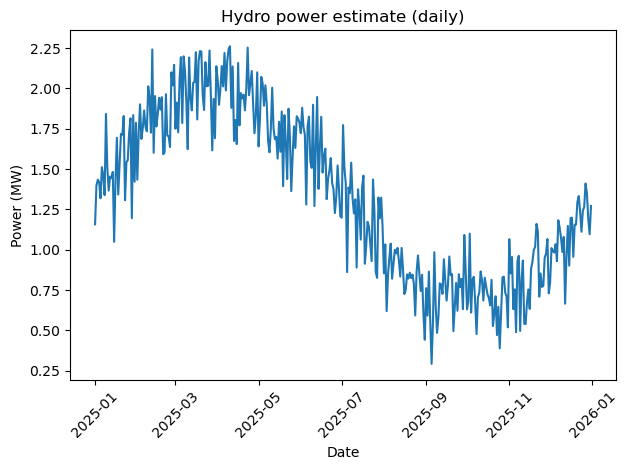

In [46]:
if TECH == "Water":
    df_w = df.copy()
    rho = 1000  # TODO: water density (kg/m^3)
    g = 9.81  # TODO: gravitational acceleration (m/s^2)
    eta = 0.85 # TODO: efficiency (dimensionless)
    H = 4.0  # TODO: head (m)

    if np.isnan(rho) or np.isnan(g) or np.isnan(eta) or np.isnan(H):
        raise ValueError("Set rho, g, eta, H (and justify) before running the Water branch.")

    Q = df_w["flow_m3_s"].to_numpy()
    P_W = rho*g*H*Q*eta  # TODO: compute hydro power in Watts using rho, g, eta, H, and Q
    df_w["power_MW"] = P_W / 1e6 #convert to MW

    # daily samples: dt = 1 day
    dt_seconds = 24*3600
    E_MWh = (trapz_integral(df_w["power_MW"], dt_seconds))/3600 # TODO: compute annual energy in MWh using trapz_integral on df_w["power_MW"] with dt=dt_seconds


    print(f"Annual energy: {E_MWh/1000:,.1f} GWh")

    plt.figure()
    plt.plot(df_w["date"], df_w["power_MW"])
    plt.title("Hydro power estimate (daily)")
    plt.xlabel("Date")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

H - low head used for an efficiency that is higher (i.e. 40%) (Kemp et al. 2014).
Eta - The efficiency for water is very high and exceed typical values of 50%. The efficiency for water can reach upwards of 85% (Kao et al. 2014)
Gravity and Rho are constants. 

References
Kao, Shih-Chieh, Ryan A. Mcmanamay, Kevin M. Stewart, et al. 2014. New Stream-Reach Development: A Comprehensive Assessment of Hydropower Energy Potential in the United States. ORNL/TM-2013/514, 1130425. https://doi.org/10.2172/1130425.

“Very Low Head Turbine Deployment in Canada - IOPscience.” n.d. Accessed February 10, 2026. https://iopscience.iop.org/article/10.1088/1755-1315/22/6/062005/meta.

# Phase 2 — Dynamical modelling with an ODE (storage, balancing, and reliability)

Phase 1 focused on computing energy by integrating a power time series.  
Phase 2 adds **dynamics**: what happens over time when supply and demand do not match perfectly?

Many energy systems include something that **accumulates** or **buffers** energy (battery, hydrogen tank, pumped hydro reservoir, thermal storage).  
A natural mathematical language for “accumulation over time” is a **differential equation**.

---

## What is $S(t)$?

Let $S(t)$ denote the **stored energy** at time $t$.

- Units: **Joules (J)**.  
- Interpretation: how much usable energy is currently stored.

Because $S(t)$ is energy, it has a **maximum capacity**:

- $S_{\max}$ (J): the **storage capacity**, i.e. the largest energy the storage can hold.

When we plot $S(t)$, we often convert units to something more intuitive like **MWh**:
- $1\ \text{MWh} = 3.6\times 10^9\ \text{J}$.

---

## A minimal storage ODE

If $P_{\text{in}}(t)$ is the electrical power *going into* storage (W) and $P_{\text{out}}(t)$ is the power *leaving* storage (W), then

$$
\frac{dS}{dt} = P_{\text{in}}(t) - P_{\text{out}}(t).
$$

- If $P_{\text{in}}(t) > P_{\text{out}}(t)$ then $S(t)$ increases (charging).
- If $P_{\text{in}}(t) < P_{\text{out}}(t)$ then $S(t)$ decreases (discharging).
- If they are equal, $S(t)$ stays constant.

In practice, storage also has constraints:

- **Capacity constraint:** $0 \le S(t) \le S_{\max}$
- **Charge-rate constraint:** $P_{\text{in}}(t) \le P_{\text{charge,max}}$
- **Discharge-rate constraint:** $P_{\text{out}}(t) \le P_{\text{discharge,max}}$

Here:
- $P_{\text{charge,max}}$ (W) is the **maximum charging power**.
- $P_{\text{discharge,max}}$ (W) is the **maximum discharging power**.

These are engineering constraints: you cannot charge or discharge infinitely fast.

---

## What are we doing in this notebook?

We will:
1. Create a simple **demand** time series (a toy model).
2. Use your technology’s power time series as the **supply**.
3. Simulate how storage can help meet demand over time.
4. Quantify reliability: “What fraction of the time is demand met?”

This is not a full power-grid model. It is a **transparent, minimal model** that connects:
- calculus (integrating power),
- ODEs (accumulation),
- and interpretation (feasibility and constraints).

---

## Optional extension (not required): first-order lag / ramping

Some technologies cannot change output instantly. A very simple “ramping” model is

$$
\tau \frac{dP}{dt} + P = P_{\text{target}}(t),
$$

where $\tau$ is a time scale describing how quickly the system responds.  
This notebook does **not** require you to use this model, but it is a natural extension if your group wants to discuss ramp limits or smoothing.

Reference (short, reputable): SciPy ODE solving documentation  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


## Converting your dataset into a common power time series

Different technologies come with different raw data:

- Solar: irradiance (W/m²)
- Wind: wind speed (m/s)
- Water: flow rate (m³/s)
- Nuclear/Geothermal: power output already (MW)
- Fermentation: monthly energy production (MMBtu)

For Phase 2 we want a **single common object** regardless of technology:

> an hourly power time series $P_{\text{supply}}(t)$ in **Watts (W)**.

The function below performs that conversion.  
**You generally do not need to edit the function.** Instead, you will edit the **parameter choices** inside your technology branch in Phase 1 (efficiency, area, head, etc.).

If you *do* want to refine the model (optional), this function is the place where you would upgrade the mapping from “resource data” → “power”.

### Your task (write in the answer block after the cell)
- In one paragraph: explain what the function is doing for **your** technology.
- State what assumptions it makes (e.g., constant efficiency, simple caps, daily upsampling).


In [52]:
from scipy.integrate import solve_ivp
# Note: if you get an error saying that there is no module named 'scipy', you may need to install scipy in your Python environment.


def get_power_timeseries_W(tech: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Return (t_hours, P_W) for the chosen tech, aligned to an hourly grid when possible."""

    if tech == "Wind":
        rho = 1.2 
        Cp = 0.55  
        radius_m = 83.5  
        if np.isnan(rho) or np.isnan(Cp) or np.isnan(radius_m):
            raise ValueError("Set rho, Cp, radius_m (and justify) before Phase 2 Wind conversion.")
        A = np.pi * radius_m**2
        v = df["windspeed_10m_m_s"].to_numpy()
        rated_power_W = 5.0e6 
        if np.isnan(rated_power_W):
            raise ValueError("Set rated_power_W (and justify) before Phase 2 Wind conversion.")
        P_W = np.minimum(0.5*rho*A*Cp*v**3, rated_power_W)
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W,
    raise ValueError(tech)


t_hours, Pin, = get_power_timeseries_W(TECH, df)

Pin = Pin*5

len(t_hours), Pin[:5]

(8760, array([25000000., 25000000., 25000000., 25000000., 25000000.]))

### Answer (Phase 2.1)

This function for wind power is converting the given dataset into a common time power series, demonstrating the hourly wind electricity output for an entire year. The function must make assumptions to provide an accurate representation of wind turbine technology. For wind technology, this function is estimating the electrical and energy power a wind turbine has given wind speed data. Generally this function needs to make assumptions especially when given parameters, like for blade radius size, power coefficient, air density, and rated power. For this function, we used the same parameters as phase 1, (see justifications) to ensure that the function will model wind turbines accurately. Once the parameters are set, the function computers the circular area swept by the blades, given by the formula A= pi * r^2, the function then calculates the electrical power generated by wind using the same equation as phase one. Then, the function calculates the power output by multiplying by the Cp and then the rated power cap adjustments. As of now, the calculated output is just in terms of units and is not a rate, thus showing the energy output for the year in a number of timestamps. Which is the total hours in a year, to calculate the annual energy production. Our output shows that the rated power cap is always being met, thus demonstrating the efficiency of the turbine with these parameters. 

## Build a toy demand profile

To keep this notebook self-contained, we use a **toy demand profile**:
- a baseline demand
- plus a daily cycle (higher during daytime)
- plus random noise

You can edit it to match your project location. The following cell is an example. You can change it as you see fit. 


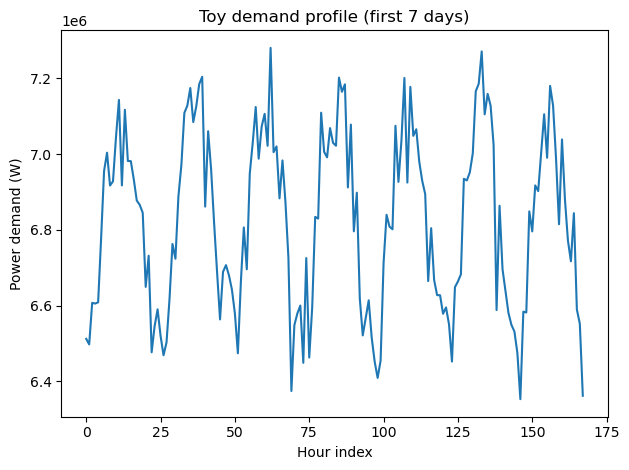

In [53]:
rng = np.random.default_rng(0)

baseline_W =  6.50e6
daily_amp_W = 0.1 * baseline_W

if np.isnan(baseline_W) or np.isnan(daily_amp_W):
    raise ValueError("Set baseline_W and daily_amp_W (and justify) before running the demand model.")

# Build a daily sinusoid with period 24 hours  
demand = baseline_W + daily_amp_W * (0.5 + 0.5*np.sin(2*np.pi*(t_hours/24.0 - 0.25)))
demand = demand + rng.normal(0, 1e5, size=len(demand))  # noise
demand = np.clip(demand, 0, None)

plt.figure()
plt.plot(t_hours[:24*7], demand[:24*7])
plt.title("Toy demand profile (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Power demand (W)")
plt.tight_layout()
plt.show()

### Answer (Phase 2.2)
The toy demand model above represents a single wind turbine and how it would behave for a given 24 hour period. The model uses a sinusoidal function to determine the demand from the baseline power and swing amplitude.The model has an input demand for an amount of power in Watts as well as for a swing amplitude (in W) that will oscillate above and below the baseline. There is a RNG or random number generation function to add a random amount to the demand to visualize the random fluctuations in energy production could look like for a given week. The value for the baseline power was determined by using data for a per capita daily use for a total of 1000 people (Government of Canada 2026). The amplitude is 10% of the baseline to approximate the energy use at peak hours such as in the evenings and lower values such as overnight. This model is simplified for a smaller population in order to create plausible expectations of an energy demand for a single turbine to meet. However, this model has limitations where the baseline cannot exceed a value too large due to this interfereing with the storage dispatch model below. Due to the random number generation, accurate wind patterns cannot be assessed using this model as is. This presents some inaccuracies compared to real life turbine demands.

References
Government of Canada, Canada Energy Regulator. 2026. “CER – British Columbia Energy Profile.” January 29. https://www.cer-rec.gc.ca/en/data-analysis/energy-markets/provincial-territorial-energy-profiles/provincial-territorial-energy-profiles-british-columbia.html.


## Storage dispatch model used below

We have:
- **Supply** $P_{\text{supply}}(t)$ (W): produced by your technology (from the earlier conversion cell).
- **Demand** $P_{\text{demand}}(t)$ (W): the load the community/system needs at time $t$.
- **Stored energy** $S(t)$ (J): how much energy is currently stored.

At each time step (1 hour), we follow this simple logic:

1. If supply exceeds demand, use supply to meet demand and put the surplus into storage (charging), up to:
   - the storage capacity $S_{\max}$ and
   - the charge-rate limit $P_{\text{charge,max}}$.
2. If supply is less than demand, discharge storage to try to cover the deficit, up to:
   - the available stored energy $S(t)$ and
   - the discharge-rate limit $P_{\text{discharge,max}}$.

This produces a time series $S(t)$ and a binary indicator: **did we meet demand at that hour?**

### Why choose $S_{\max}$?

Choosing $S_{\max}$ is a modelling decision: it encodes how much storage infrastructure you are assuming.
A useful interpretation is “how many hours of baseline demand can the storage cover?”

Example: if baseline demand is 2 MW, then 4 hours of coverage corresponds to:
$$
S_{\max} = (2\times 10^6\ \text{W})\cdot (4\ \text{h}) = 8\times 10^6\ \text{Wh} = 8\ \text{MWh}.
$$
In Joules, that is $8\ \text{MWh}\times 3.6\times 10^9\ \text{J/MWh}$.

### Your task (answer block below)
- Explain your chosen values of $S_{\max}$, $P_{\text{charge,max}}$, and $P_{\text{discharge,max}}$.
- Give a short “engineering meaning” (e.g., hours of coverage, plausible charge/discharge rate).


Fraction of hours demand met: 0.896


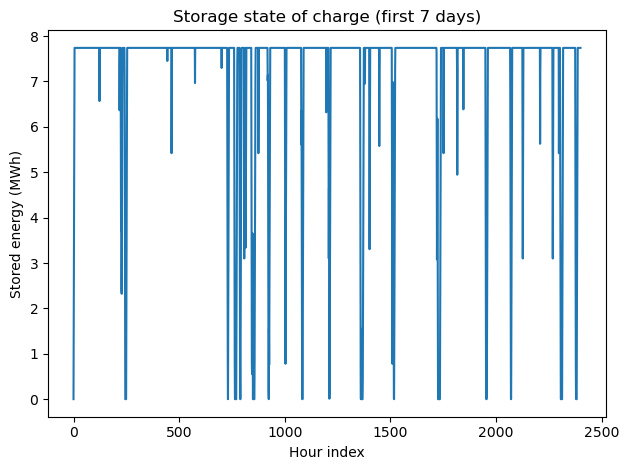

In [54]:
S_max_J = 7.74e6*3600  #6 hours of storage
P_charge_max = 1.55e6  #20% of max storage
P_discharge_max = 2.32e6 #50% higher than p_charge_max
if np.isnan(S_max_J) or np.isnan(P_charge_max) or np.isnan(P_discharge_max):
    raise ValueError("Set S_max_J, P_charge_max, P_discharge_max (and justify) before running the storage simulation.")

dt = 3600.0  # seconds per step (hourly)

S = np.zeros(len(t_hours))
met = np.zeros(len(t_hours), dtype=bool)

for k in range(1, len(t_hours)):
    # available surplus/deficit before storage
    surplus = Pin[k-1] - demand[k-1]
    if surplus >= 0:
        # charge storage
        charge = min(surplus, P_charge_max)
        S[k] = min(S_max_J, S[k-1] + charge*dt)
        supplied = demand[k-1]
        met[k-1] = True
    else:
        # discharge if possible
        need = -surplus
        discharge = min(need, P_discharge_max, S[k-1]/dt)
        supplied = Pin[k-1] + discharge
        S[k] = max(0.0, S[k-1] - discharge*dt)
        met[k-1] = supplied >= demand[k-1] - 1e-6

# summarize
fraction_met = met.mean()
print(f"Fraction of hours demand met: {fraction_met:.3f}")

plt.figure()
plt.plot(t_hours[:24*100], S[:24*100]/3.6e9)  # J to MWh (1 MWh = 3.6e9 J)
plt.title("Storage state of charge (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.tight_layout()
plt.show()

## Numerically solving the ODE with `solve_ivp` (required)

The loop above is a **discrete-time simulation** (hour-by-hour bookkeeping).  
In this section you will also solve a **continuous-time ODE** using SciPy.

### ODE we solve

We model stored energy $S(t)$ (J) with:

$$
\frac{dS}{dt} = u(t),
$$

where $u(t)$ is the **net charging power** (W) after applying rate limits and storage bounds.

Let $P_{\text{supply}}(t)$ be supply and $P_{\text{demand}}(t)$ be demand. Define the unconstrained net power:
$$
u_0(t) = P_{\text{supply}}(t) - P_{\text{demand}}(t).
$$

We then apply the **power limits**:
- charging cannot exceed $P_{\text{charge,max}}$
- discharging cannot exceed $P_{\text{discharge,max}}$

and also prevent $S(t)$ from leaving $[0,S_{\max}]$ by setting $u(t)=0$ when the storage is full and would charge, or empty and would discharge.

### Your task
- Run the ODE solver and compare its $S(t)$ curve to the discrete simulation.
- Briefly explain why the curves may not match exactly (hint: discretization, piecewise definitions, interpolation).


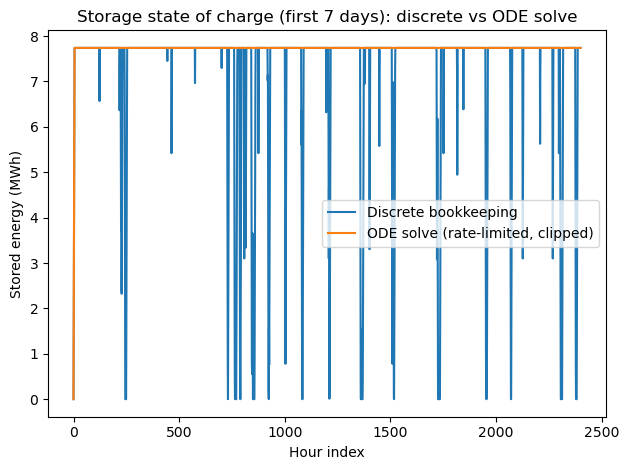

solve_ivp success: True
solve_ivp message: The solver successfully reached the end of the integration interval.


In [55]:
# ODE solve using solve_ivp (continuous time)

from scipy.interpolate import interp1d

# Hourly samples indexed by t_hours (0,1,2,...) and arrays Pin (supply) and demand.
# Convert to seconds for the ODE solver.
t_sec = t_hours * 3600.0

# Use "previous" interpolation so the solver sees piecewise-constant inputs within each hour.
Pin_fun = interp1d(t_sec, Pin, kind="previous", fill_value="extrapolate")
demand_fun = interp1d(t_sec, demand, kind="previous", fill_value="extrapolate")

def dSdt(t, S):
    """dS/dt in J/s. We apply ONLY power-rate limits here.

    Note: enforcing hard bounds (0 <= S <= S_max) directly inside the RHS can create
    discontinuities that make adaptive ODE solvers struggle. We instead:
      1) solve the rate-limited ODE, then
      2) clip S(t) to [0, S_max] for interpretation/plots.
    """
    u0 = float(Pin_fun(t) - demand_fun(t))  # net power (W) = J/s
    # Apply charge/discharge power limits
    u = min(u0, float(P_charge_max))
    u = max(u, -float(P_discharge_max))
    return [u]

# Initial condition (start empty)
S0 = [0.0]

sol = solve_ivp(
    dSdt,
    t_span=(t_sec[0], t_sec[-1]),
    y0=S0,
    t_eval=t_sec,
    method="RK23",
    rtol=1e-4,
    atol=1.0,
    max_step=3600.0,
)

S_ode_raw = sol.y[0] if sol.y is not None else None

# If the solver fails (rare but possible), fall back to a direct numerical integral.
if (not sol.success) or (S_ode_raw is None) or (len(S_ode_raw) != len(t_sec)):
    print("solve_ivp did not succeed; falling back to trapezoid integration.")
    print("Message:", sol.message)
    u_hourly = np.clip(Pin - demand, -float(P_discharge_max), float(P_charge_max))
    S_ode_raw = np.concatenate([[0.0], np.cumsum(u_hourly[:-1] * 3600.0)])

# Clip to physical bounds for interpretation
S_ode = np.clip(S_ode_raw, 0.0, float(S_max_J))

plt.figure()
plt.plot(t_hours[:24*100], (S[:24*100] / 3.6e9), label="Discrete bookkeeping")
plt.plot(t_hours[:24*100], (S_ode[:24*100] / 3.6e9), label="ODE solve (rate-limited, clipped)")
plt.title("Storage state of charge (first 7 days): discrete vs ODE solve")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

print("solve_ivp success:", sol.success)
print("solve_ivp message:", sol.message)


### Answer (Phase 2.4)

Both the discrete and ODE curves have a large increase over the first 300 hours, however the discrete model begins to have small up-turned curves whereas the ODE remains horizontal after the initial increase. The discrete model and ODE curves are visually different due to how the ODE uses a finite interval that although simplifies the model, it does so by also reducing the data to have a less complex model overall. The ODE also uses SciPi to estimate data that is unknown, filling the gaps between the set data values. This results in a much smoother curve with much less jumps in data points, especially when the hour index is greater than 500. For the purpose of a simple model, the discrete curve is best suited to show the exact data points without making assumptions to create a smoother visual. This is more accurate to real life models as well since there may be large jumps in data points due to differences in wind patterns. If a visual was needed to see general trends in storage, then the ODE curve would be most effective for this purpose. 

*Compare the discrete and ODE curves. Why do they differ? Which do you trust more for which purpose?*

### Answer (Phase 2.3)

Parameters Smax, Pcharge max, and Pdischarge max are chosen for the storage model based on toy demand and power output profiles are. We decided to use a baseline demand of energy for 1000 individuals in our location, Prince Rupert, BC using wind technology. To find Smax we multiplied the baseline energy daily for the population of around 1000 individuals in Prince Rupert BC, then we multiplied this value by 6 hours, as we want the battery to be able to store enough energy to sustain this population for at least 6 hours. Finally, dimensional analysis to convert this value into a measure of Joules resulting in 2.79e10 J. As Prince Rupert is sufficiently windy, a 6 hours stored capacity should be sufficient to depend on electricity produced by wind. Pcharge max was chosen to be. Pcharge max refers to the maximum rate in which the battery can be charged. Pdischarge refers to the rate in which the battery can safely deliver energy. Typically the Pdischarge is greater than the Pcharge, which is why our chosen Pdischarge is 50% greater than the charging rate, thus we chose 2.32e6 J (“Unveiling the Impacts of Charge/Discharge Rate on the Cycling Performance of Li-Metal Batteries | ACS Energy Letters,” n.d). Increasing the value of Pcharge and Discharge increases the fraction of energy demand hours being met. In this toy model the code was altered to evaluate the demand for five turbines. Resulting in a fraction of 0.998 hours of demand met, roughly 100%. Thus, with the increase of turbines the demand is approximately fully met at each hour. This model fails to meet the demand during periods of very high wind speeds (which are unsafe for the turbines, so they slow down) or during periods of very low winds when a minimum wind speed is not met. During peak energy uses, the discharge may be much larger than the charge value, which provides some unreliability in the model. 

References
“Unveiling the Impacts of Charge/Discharge Rate on the Cycling Performance of Li-Metal Batteries | ACS Energy Letters.” n.d. Accessed February 10, 2026. https://pubs.acs.org/doi/10.1021/acsenergylett.4c03215.

## Final checklist (before submission)

- [ ] Notebook runs top-to-bottom with no errors.  
- [ ] All **embedded checks** pass.  
- [ ] You wrote short markdown justifications for chosen parameters (efficiency, area, head, storage size, etc.).  
- [ ] You created at least **one plot** that supports interpretation in Phase 1 and **one plot** in Phase 2.  
- [ ] Your group repository is **public** and shared among members; includes `README.md`.  
- [ ] You are ready to cite your repo (link) in the final write-up if you use this work.

